In [1]:
# Установка необходимых библиотек (выполнить один раз)
!pip install psycopg2-binary pandas matplotlib seaborn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.4 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 7.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.9/432.9 kB 13.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import psycopg2
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('✓ Библиотеки загружены успешно')

✓ Библиотеки загружены успешно


In [3]:
# Параметры подключения к БД
DB_CONFIG = {
    'host': 'postgres',  # Имя сервиса в Docker
    'port': 5432,
    'dbname': 'weather_db',
    'user': 'weather_user',
    'password': 'weather_pass'
}

def get_connection():
    """Создаёт подключение к базе данных"""
    return psycopg2.connect(**DB_CONFIG)

def load_data(query):
    """Загружает данные из БД в DataFrame"""
    conn = get_connection()
    df = pd.read_sql(query, conn)
    conn.close()
    return df

print('✓ Функции подключения готовы')

✓ Функции подключения готовы


## 📊 Загрузка и обзор данных

In [4]:
# Загрузка всех данных погодной станции
query = """
SELECT id, timestamp, temperature, humidity, pressure, 
       wind_speed, wind_direction, weather_condition
FROM weather_data
ORDER BY timestamp DESC
"""

df = load_data(query)

print(f'Загружено записей: {len(df)}')
print(f'Период данных: с {df["timestamp"].min()} по {df["timestamp"].max()}')
print('\nПервые 5 записей:')
df.head()

Загружено записей: 141
Период данных: с 2026-01-15 09:09:38.305882+00:00 по 2026-01-15 09:11:59.149978+00:00

Первые 5 записей:


,id,timestamp,temperature,humidity,pressure,wind_speed,wind_direction,weather_condition
0,141,2026-01-15 09:11:59.149978+00:00,19.43,21.77,1024.29,2.64,N,Ясно
1,140,2026-01-15 09:11:58.140593+00:00,19.72,20.00,1023.95,3.03,N,Ясно
2,139,2026-01-15 09:11:57.137119+00:00,19.50,20.00,1024.63,3.08,N,Малооблачно
3,138,2026-01-15 09:11:56.134944+00:00,19.60,20.00,1024.70,3.24,N,Ясно
4,137,2026-01-15 09:11:55.128760+00:00,19.66,20.00,1025.12,4.36,N,Облачно


In [5]:
# Общая статистика по числовым полям
print('📈 Статистика по показаниям погодной станции:\n')
df[['temperature', 'humidity', 'pressure', 'wind_speed']].describe().round(2)

📈 Статистика по показаниям погодной станции:



,temperature,humidity,pressure,wind_speed
count,141.00,141.00,141.00,141.00
mean,25.84,31.31,1016.10,2.66
std,3.66,12.86,5.23,0.77
min,19.26,20.00,1011.73,1.02
25%,20.27,20.18,1012.75,2.13
50%,27.90,24.26,1013.22,2.55
75%,28.14,41.68,1023.95,3.17
max,28.60,65.48,1025.70,5.46


## 🌡️ Анализ температуры

In [6]:
# График температуры во времени
fig = px.line(df.sort_values('timestamp'), 
              x='timestamp', y='temperature',
              title='🌡️ Изменение температуры во времени',
              labels={'temperature': 'Температура (°C)', 'timestamp': 'Время'})
fig.update_layout(height=400)
fig.show()

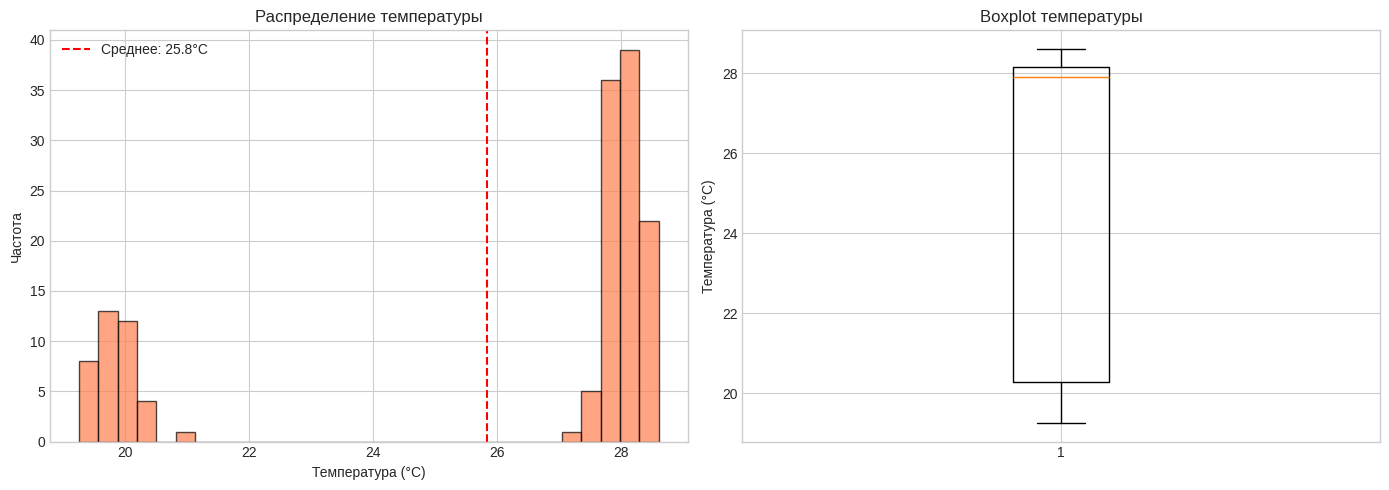

In [7]:
# Распределение температуры
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(df['temperature'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Температура (°C)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение температуры')
axes[0].axvline(df['temperature'].mean(), color='red', linestyle='--', label=f'Среднее: {df["temperature"].mean():.1f}°C')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['temperature'], vert=True)
axes[1].set_ylabel('Температура (°C)')
axes[1].set_title('Boxplot температуры')

plt.tight_layout()
plt.show()

## 💧 Анализ влажности и давления

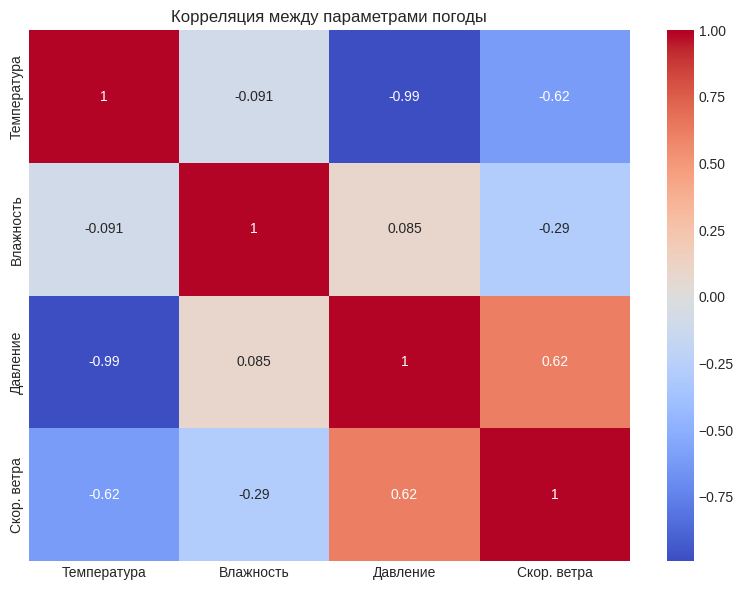

In [8]:
# Корреляция между параметрами
correlation_matrix = df[['temperature', 'humidity', 'pressure', 'wind_speed']].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=['Температура', 'Влажность', 'Давление', 'Скор. ветра'],
            yticklabels=['Температура', 'Влажность', 'Давление', 'Скор. ветра'])
ax.set_title('Корреляция между параметрами погоды')
plt.tight_layout()
plt.show()

In [9]:
# Scatter plot: Температура vs Влажность
fig = px.scatter(df, x='temperature', y='humidity', color='weather_condition',
                 title='Зависимость влажности от температуры',
                 labels={'temperature': 'Температура (°C)', 'humidity': 'Влажность (%)'},
                 opacity=0.6)
fig.update_layout(height=500)
fig.show()

## 💨 Анализ ветра

In [10]:
# Распределение направлений ветра (роза ветров)
wind_counts = df['wind_direction'].value_counts()

# Порядок направлений для корректного отображения
directions_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
wind_counts = wind_counts.reindex(directions_order).fillna(0)

fig = go.Figure()
fig.add_trace(go.Barpolar(
    r=wind_counts.values,
    theta=directions_order,
    marker_color='rgb(106, 168, 79)',
    opacity=0.8
))

fig.update_layout(
    title='🧭 Роза ветров (распределение направлений)',
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(direction='clockwise')
    ),
    height=500
)
fig.show()

In [11]:
# Средняя скорость ветра по направлениям
wind_speed_by_direction = df.groupby('wind_direction')['wind_speed'].agg(['mean', 'max']).round(2)
wind_speed_by_direction = wind_speed_by_direction.reindex(directions_order)

print('Средняя и максимальная скорость ветра по направлениям:\n')
wind_speed_by_direction.columns = ['Средняя (м/с)', 'Максимальная (м/с)']
wind_speed_by_direction

Средняя и максимальная скорость ветра по направлениям:



,Средняя (м/с),Максимальная (м/с)
wind_direction,,
N,3.44,5.46
NE,NaN,NaN
E,1.77,2.34
SE,2.28,4.10
S,2.68,3.75
SW,NaN,NaN
W,NaN,NaN
NW,NaN,NaN


## ☁️ Анализ погодных условий

In [12]:
# Распределение погодных условий
weather_counts = df['weather_condition'].value_counts()

fig = px.pie(values=weather_counts.values, names=weather_counts.index,
             title='☁️ Распределение погодных условий',
             hole=0.4)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500)
fig.show()

In [13]:
# Средние показатели по типу погоды
weather_stats = df.groupby('weather_condition').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'pressure': 'mean',
    'wind_speed': 'mean'
}).round(2)

weather_stats.columns = ['Средняя температура (°C)', 'Средняя влажность (%)', 
                          'Среднее давление (гПа)', 'Средняя скорость ветра (м/с)']

print('📊 Средние показатели по типу погоды:\n')
weather_stats

📊 Средние показатели по типу погоды:



,Средняя температура (°C),Средняя влажность (%),Среднее давление (гПа),Средняя скорость ветра (м/с)
weather_condition,,,,
Гроза,27.97,21.91,1012.83,2.72
Дождь,27.87,31.55,1013.32,2.74
Малооблачно,25.23,32.60,1016.91,2.70
Небольшой дождь,28.04,36.36,1012.74,1.94
Облачно,26.49,30.53,1015.22,2.52
Пасмурно,27.97,24.51,1012.91,2.81
Туман,27.96,21.55,1013.22,2.34
Ясно,24.39,31.80,1018.25,2.89


## 📈 Итоговая сводка

In [14]:
# Итоговая статистика
print('=' * 60)
print('📊 ИТОГОВАЯ СВОДКА ДАННЫХ ПОГОДНОЙ СТАНЦИИ')
print('=' * 60)
print(f'\n📅 Период наблюдений:')
print(f'   Начало: {df["timestamp"].min()}')
print(f'   Конец:  {df["timestamp"].max()}')
print(f'   Всего записей: {len(df)}')
print(f'\n🌡️ Температура:')
print(f'   Минимум: {df["temperature"].min():.1f}°C')
print(f'   Максимум: {df["temperature"].max():.1f}°C')
print(f'   Среднее: {df["temperature"].mean():.1f}°C')
print(f'\n💧 Влажность:')
print(f'   Минимум: {df["humidity"].min():.1f}%')
print(f'   Максимум: {df["humidity"].max():.1f}%')
print(f'   Среднее: {df["humidity"].mean():.1f}%')
print(f'\n📊 Давление:')
print(f'   Минимум: {df["pressure"].min():.1f} гПа')
print(f'   Максимум: {df["pressure"].max():.1f} гПа')
print(f'   Среднее: {df["pressure"].mean():.1f} гПа')
print(f'\n💨 Скорость ветра:')
print(f'   Минимум: {df["wind_speed"].min():.1f} м/с')
print(f'   Максимум: {df["wind_speed"].max():.1f} м/с')
print(f'   Среднее: {df["wind_speed"].mean():.1f} м/с')
print(f'\n☁️ Самое частое состояние погоды: {df["weather_condition"].mode()[0]}')
print('=' * 60)

📊 ИТОГОВАЯ СВОДКА ДАННЫХ ПОГОДНОЙ СТАНЦИИ

📅 Период наблюдений:
   Начало: 2026-01-15 09:09:38.305882+00:00
   Конец:  2026-01-15 09:11:59.149978+00:00
   Всего записей: 141

🌡️ Температура:
   Минимум: 19.3°C
   Максимум: 28.6°C
   Среднее: 25.8°C

💧 Влажность:
   Минимум: 20.0%
   Максимум: 65.5%
   Среднее: 31.3%

📊 Давление:
   Минимум: 1011.7 гПа
   Максимум: 1025.7 гПа
   Среднее: 1016.1 гПа

💨 Скорость ветра:
   Минимум: 1.0 м/с
   Максимум: 5.5 м/с
   Среднее: 2.7 м/с

☁️ Самое частое состояние погоды: Ясно
